# YOLO 용 label 만들기

In [ ]:
import json
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm

def create_yolo_bbox_labels_from_interp(
    interp_root: Path,
    frame_root: Path,
    output_root: Path,
    margin_ratio: float = 1.5,
    min_size: int = 30
):
    """
    4_INTERP_DATA 내 keypoints JSON을 기반으로 YOLOv11용 bbox 라벨(.txt) 자동 생성

    Args:
        interp_root (Path): 4_INTERP_DATA 루트 경로
        frame_root (Path): 1_FRAME 루트 경로 (이미지 크기 확인용)
        output_root (Path): 5_YOLO/YOLOv11_bbox 저장 경로
        margin_ratio (float): bbox 여유 비율 (기본=1.5)
        min_size (int): bbox 최소 크기 (픽셀 단위, 기본=30)
    """
    print(f"[INFO] BBox 라벨 생성 시작")
    print(f" - 입력 JSON 경로: {interp_root}")
    print(f" - 출력 라벨 경로: {output_root}")
    print(f" - margin_ratio={margin_ratio}, min_size={min_size}")

    # 모든 JSON 파일 탐색
    json_files = sorted(interp_root.rglob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 파일 발견")

    for jf in tqdm(json_files, desc="[CREATE] YOLO BBox Labels"):
        # -------------------------------------------------------
        # 1️⃣ JSON 로드 및 keypoints 추출
        # -------------------------------------------------------
        try:
            with open(jf, "r", encoding="utf-8") as f:
                data = json.load(f)
            kps = np.array(data["instance_info"][0]["keypoints"])
            kps = kps[5:17]  # 5~16번 keypoints만 사용
            kps = np.nan_to_num(kps, nan=0.0)

            # 유효 keypoints 필터링 (x>0, y>0)
            valid_mask = np.logical_and(kps[:, 0] > 0, kps[:, 1] > 0)
            kps = kps[valid_mask]
            if len(kps) < 2:
                continue
        except Exception as e:
            print(f"[WARN] JSON 파싱 오류: {jf.name} ({e})")
            continue

        # -------------------------------------------------------
        # 2️⃣ 대응 이미지 탐색 및 크기 확인
        # -------------------------------------------------------
        frame_name = jf.stem + ".jpg"
        frame_candidates = list(frame_root.rglob(frame_name))
        if not frame_candidates:
            # .png fallback
            frame_candidates = list(frame_root.rglob(jf.stem + ".png"))
        if not frame_candidates:
            print(f"[WARN] 대응 이미지 없음: {frame_name}")
            continue

        frame_path = frame_candidates[0]
        frame = cv2.imread(str(frame_path))
        if frame is None:
            print(f"[WARN] 이미지 로드 실패: {frame_path}")
            continue
        img_h, img_w = frame.shape[:2]

        # -------------------------------------------------------
        # 3️⃣ BBox 계산
        # -------------------------------------------------------
        x_min, x_max = np.min(kps[:, 0]), np.max(kps[:, 0])
        y_min, y_max = np.min(kps[:, 1]), np.max(kps[:, 1])

        cx = (x_min + x_max) / 2
        cy = (y_min + y_max) / 2
        w = x_max - x_min
        h = y_max - y_min

        # 최소 bbox 크기 보장
        w = max(w, min_size)
        h = max(h, min_size)

        # margin 적용
        w *= margin_ratio
        h *= margin_ratio

        # clip (이미지 크기 내로 제한)
        x_min = max(cx - w / 2, 0)
        y_min = max(cy - h / 2, 0)
        x_max = min(cx + w / 2, img_w)
        y_max = min(cy + h / 2, img_h)

        # YOLO 정규화 (cx, cy, w, h → [0,1])
        cx_n = ((x_min + x_max) / 2) / img_w
        cy_n = ((y_min + y_max) / 2) / img_h
        w_n = (x_max - x_min) / img_w
        h_n = (y_max - y_min) / img_h

        # -------------------------------------------------------
        # 4️⃣ 출력 경로 생성 및 저장
        # -------------------------------------------------------
        rel_path = jf.relative_to(interp_root)
        out_label_dir = output_root / rel_path.parent / "labels"
        out_label_dir.mkdir(parents=True, exist_ok=True)
        out_label_path = out_label_dir / f"{jf.stem}.txt"

        with open(out_label_path, "w") as f:
            f.write(f"0 {cx_n:.6f} {cy_n:.6f} {w_n:.6f} {h_n:.6f}\n")

    print(f"\n✅ YOLOv11 BBox 라벨 생성 완료 → {output_root}")


[INFO] metadata 로드 완료: 83개 유효 항목
[INFO] 선택된 샘플:
 - interp_json_path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N01/N01_Ward/diagonal__bridge_static
 - frame_path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/1_FRAME/AI_dataset/N01/N01_Ward/diagonal__bridge_static
[INFO] 선택된 JSON 파일: 000100.json

[DEBUG] --- 000100.json ---
[DEBUG] 이미지 크기: width=1280, height=720
[DEBUG] x_min=591.3, x_max=814.5
[DEBUG] y_min=409.7, y_max=536.9
[DEBUG] 초기 bbox 중심(cx,cy)=(702.9,473.3), 폭=223.3, 높이=127.2
[DEBUG] margin 적용 후 폭=334.9, 높이=190.8 (×1.5)
[DEBUG] 최종 bbox 좌표: x_min=535.4, y_min=377.9, x_max=870.4, y_max=568.7



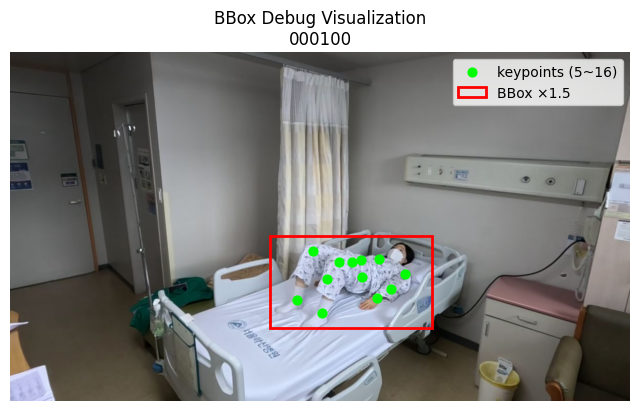

[INFO] BBox 최종 크기: 334.9 x 190.8


In [ ]:
# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data")

INTERP_DIR = BASE_DIR / "4_INTERP_DATA/AI_dataset/N01"     # 입력 JSON 폴더
FRAME_DIR  = BASE_DIR / "1_FRAME/AI_dataset/N01"           # 이미지 폴더
YOLO_BBOX_DIR = BASE_DIR / "5_YOLO/YOLOv11_bbox"           # 출력 경로

# -------------------------------------------------------
# 실행
# -------------------------------------------------------
create_yolo_bbox_labels_from_interp(
    interp_root=INTERP_DIR,
    frame_root=FRAME_DIR,
    output_root=YOLO_BBOX_DIR,
    margin_ratio=1.5,
    min_size=30
)


## 실제 생성

In [ ]:
import json
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm

def create_yolo_bbox_labels_from_interp(
    interp_root: Path,
    frame_root: Path,
    output_root: Path,
    margin_ratio: float = 1.5,
    min_size: int = 30
):
    """
    4_INTERP_DATA 내 keypoints JSON을 기반으로 YOLOv11용 bbox 라벨(.txt) 자동 생성

    Args:
        interp_root (Path): 4_INTERP_DATA 루트 경로
        frame_root (Path): 1_FRAME 루트 경로 (이미지 크기 확인용)
        output_root (Path): 5_YOLO/YOLOv11_bbox 저장 경로
        margin_ratio (float): bbox 여유 비율 (기본=1.5)
        min_size (int): bbox 최소 크기 (픽셀 단위, 기본=30)
    """
    print(f"[INFO] BBox 라벨 생성 시작")
    print(f" - 입력 JSON 경로: {interp_root}")
    print(f" - 출력 라벨 경로: {output_root}")
    print(f" - margin_ratio={margin_ratio}, min_size={min_size}")

    # 모든 JSON 파일 탐색
    json_files = sorted(interp_root.rglob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 파일 발견")

    for jf in tqdm(json_files, desc="[CREATE] YOLO BBox Labels"):
        # -------------------------------------------------------
        # 1️⃣ JSON 로드 및 keypoints 추출
        # -------------------------------------------------------
        try:
            with open(jf, "r", encoding="utf-8") as f:
                data = json.load(f)
            kps = np.array(data["instance_info"][0]["keypoints"])
            kps = kps[5:17]  # 5~16번 keypoints만 사용
            kps = np.nan_to_num(kps, nan=0.0)

            # 유효 keypoints 필터링 (x>0, y>0)
            valid_mask = np.logical_and(kps[:, 0] > 0, kps[:, 1] > 0)
            kps = kps[valid_mask]
            if len(kps) < 2:
                continue
        except Exception as e:
            print(f"[WARN] JSON 파싱 오류: {jf.name} ({e})")
            continue

        # -------------------------------------------------------
        # 2️⃣ 대응 이미지 탐색 및 크기 확인
        # -------------------------------------------------------
        frame_name = jf.stem + ".jpg"
        frame_candidates = list(frame_root.rglob(frame_name))
        if not frame_candidates:
            # .png fallback
            frame_candidates = list(frame_root.rglob(jf.stem + ".png"))
        if not frame_candidates:
            print(f"[WARN] 대응 이미지 없음: {frame_name}")
            continue

        frame_path = frame_candidates[0]
        frame = cv2.imread(str(frame_path))
        if frame is None:
            print(f"[WARN] 이미지 로드 실패: {frame_path}")
            continue
        img_h, img_w = frame.shape[:2]

        # -------------------------------------------------------
        # 3️⃣ BBox 계산
        # -------------------------------------------------------
        x_min, x_max = np.min(kps[:, 0]), np.max(kps[:, 0])
        y_min, y_max = np.min(kps[:, 1]), np.max(kps[:, 1])

        cx = (x_min + x_max) / 2
        cy = (y_min + y_max) / 2
        w = x_max - x_min
        h = y_max - y_min

        # 최소 bbox 크기 보장
        w = max(w, min_size)
        h = max(h, min_size)

        # margin 적용
        w *= margin_ratio
        h *= margin_ratio

        # clip (이미지 크기 내로 제한)
        x_min = max(cx - w / 2, 0)
        y_min = max(cy - h / 2, 0)
        x_max = min(cx + w / 2, img_w)
        y_max = min(cy + h / 2, img_h)

        # YOLO 정규화 (cx, cy, w, h → [0,1])
        cx_n = ((x_min + x_max) / 2) / img_w
        cy_n = ((y_min + y_max) / 2) / img_h
        w_n = (x_max - x_min) / img_w
        h_n = (y_max - y_min) / img_h

        # -------------------------------------------------------
        # 4️⃣ 출력 경로 생성 및 저장
        # -------------------------------------------------------
        rel_path = jf.relative_to(interp_root)
        out_label_dir = output_root / rel_path.parent / "labels"
        out_label_dir.mkdir(parents=True, exist_ok=True)
        out_label_path = out_label_dir / f"{jf.stem}.txt"

        with open(out_label_path, "w") as f:
            f.write(f"0 {cx_n:.6f} {cy_n:.6f} {w_n:.6f} {h_n:.6f}\n")

    print(f"\n✅ YOLOv11 BBox 라벨 생성 완료 → {output_root}")



In [7]:
import pandas as pd
from pathlib import Path

# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data")
CSV_PATH = BASE_DIR / "metadata_new3_sorted.csv"

# -------------------------------------------------------
# CSV 로드
# -------------------------------------------------------
meta = pd.read_csv(CSV_PATH)
print(f"[INFO] metadata 로드 완료: {meta.shape[0]} rows")

# -------------------------------------------------------
# 새로운 경로 컬럼 생성
# -------------------------------------------------------
def make_interp_path(frame_path: str) -> str:
    """1_FRAME 경로를 4_INTERP_DATA 경로로 변환"""
    return str(frame_path).replace("1_FRAME", "4_INTERP_DATA")

def make_yolo_bbox_path(frame_path: str) -> str:
    """1_FRAME 경로를 5_YOLO/YOLOv11_bbox 경로로 변환"""
    return str(frame_path).replace("1_FRAME", "5_YOLO/YOLOv11_bbox")

def make_yolo_pose_path(frame_path: str) -> str:
    """1_FRAME 경로를 5_YOLO/YOLOv11_pose 경로로 변환"""
    return str(frame_path).replace("1_FRAME", "5_YOLO/YOLOv11_pose")

# -------------------------------------------------------
# 컬럼 추가 (존재하는 경우 무시)
# -------------------------------------------------------
meta["interp_json_path"] = meta["frame_path"].apply(make_interp_path)
meta["yolo_bbox_path"] = meta["frame_path"].apply(make_yolo_bbox_path)
meta["yolo_pose_path"] = meta["frame_path"].apply(make_yolo_pose_path)

print(f"[INFO] 신규 컬럼 추가 완료:")
print(meta[["frame_path", "interp_json_path", "yolo_bbox_path", "yolo_pose_path"]].head(3))

# -------------------------------------------------------
# 새 CSV 저장
# -------------------------------------------------------
OUT_PATH = BASE_DIR / "metadata_yolo_final.csv"
meta.to_csv(OUT_PATH, index=False)
print(f"\n✅ 저장 완료 → {OUT_PATH}")


[INFO] metadata 로드 완료: 1158 rows
[INFO] 신규 컬럼 추가 완료:
                                          frame_path  \
0  1_FRAME/AI_dataset/N01/N01_Treatment/diagonal_...   
1  1_FRAME/AI_dataset/N01/N01_Treatment/diagonal_...   
2  1_FRAME/AI_dataset/N01/N01_Treatment/diagonal_...   

                                    interp_json_path  \
0  4_INTERP_DATA/AI_dataset/N01/N01_Treatment/dia...   
1  4_INTERP_DATA/AI_dataset/N01/N01_Treatment/dia...   
2  4_INTERP_DATA/AI_dataset/N01/N01_Treatment/dia...   

                                      yolo_bbox_path  \
0  5_YOLO/YOLOv11_bbox/AI_dataset/N01/N01_Treatme...   
1  5_YOLO/YOLOv11_bbox/AI_dataset/N01/N01_Treatme...   
2  5_YOLO/YOLOv11_bbox/AI_dataset/N01/N01_Treatme...   

                                      yolo_pose_path  
0  5_YOLO/YOLOv11_pose/AI_dataset/N01/N01_Treatme...  
1  5_YOLO/YOLOv11_pose/AI_dataset/N01/N01_Treatme...  
2  5_YOLO/YOLOv11_pose/AI_dataset/N01/N01_Treatme...  

✅ 저장 완료 → /workspace/nas203/ds_RehabilitationMedici